<a href="https://colab.research.google.com/github/purvasingh96/Deep-Reinforcement-Learning/blob/master/4.%20Deep%20Q%20Networks/Credit_Card_Fraud_Detection_via_DQNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

# Gymnasium = maintained Gym replacement
!"{sys.executable}" -m pip install -U pip
!"{sys.executable}" -m pip install -U gymnasium numpy pandas scikit-learn torch matplotlib

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------------- ---------------------- 0.8/1.8 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
  Using cached numpy-2.4.0-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
   ---------------------------------------- 0.0/952.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/952.1 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/952.1 kB ? eta -:--:--
   --------------------------------- ------ 786.4/952.1 kB 1.5 M

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.4.0 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.0 which is incompatible.


In [3]:
from pathlib import Path
import pandas as pd

def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    while p != p.parent:
        if (p / "dataset" / "creditcard.csv").exists():
            return p
        p = p.parent
    raise FileNotFoundError("Could not find dataset/creditcard.csv above current folder")

repo_root = find_repo_root(Path.cwd())
csv_path = repo_root / "dataset" / "creditcard.csv"

print("Repo root:", repo_root)
print("CSV path:", csv_path)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print(df.head(2))
print("Class balance:\n", df["Class"].value_counts())

Repo root: C:\Users\User\OneDrive\Desktop\RL\gym-fraud
CSV path: C:\Users\User\OneDrive\Desktop\RL\gym-fraud\dataset\creditcard.csv
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  

[2 rows x 31 columns]
Class balance:
 Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X = all columns except label, y = Class (0/1)
X_raw = df.drop(columns=["Class"]).to_numpy(dtype=np.float32)
y = df["Class"].to_numpy(dtype=np.int64)

# Stratified split so fraud ratio is preserved
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale features using ONLY training data statistics
scaler = StandardScaler()
X_train = scaler.fit_transform(X_raw[train_idx]).astype(np.float32)
X_test = scaler.transform(X_raw[test_idx]).astype(np.float32)

y_train = y[train_idx]
y_test = y[test_idx]

print("X_train:", X_train.shape, "y_train:", y_train.shape, "fraud%:", y_train.mean() * 100)
print("X_test :", X_test.shape,  "y_test :", y_test.shape,  "fraud%:", y_test.mean() * 100)
print("Feature dim:", X_train.shape[1])

X_train: (227845, 30) y_train: (227845,) fraud%: 0.17292457591783889
X_test : (56962, 30) y_test : (56962,) fraud%: 0.17204452090867595
Feature dim: 30


In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class FraudWindowEnv(gym.Env):
    """
    Level 1: episodes are short windows of transactions.
    Each step: observe one transaction -> choose action (0 legit / 1 fraud) -> get reward -> move to next.
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        episode_len: int = 200,
        seed: int | None = 42,
        shuffle: bool = True,
        reward_cfg: dict | None = None,
    ):
        super().__init__()
        assert X.ndim == 2, "X must be (N, D)"
        assert y.ndim == 1 and len(y) == len(X), "y must be (N,) aligned with X"

        self.X = X.astype(np.float32, copy=False)
        self.y = y.astype(np.int64, copy=False)
        self.n, self.d = self.X.shape

        self.episode_len = int(min(max(1, episode_len), self.n))
        self.shuffle = bool(shuffle)
        self.rng = np.random.default_rng(seed)

        # Cost-sensitive rewards (fraud is rare):
        # - Missing fraud (FN) is worst
        # - False alarms (FP) are bad but less severe
        # - TN small positive to avoid "always flag"
        # - TP good
        self.reward_cfg = reward_cfg or {"tp": 1.0, "tn": 0.05, "fp": -0.5, "fn": -2.0}

        self.action_space = spaces.Discrete(2)  # 0=legit, 1=fraud
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.d,), dtype=np.float32
        )

        self.order = None
        self.t = 0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.t = 0
        if self.shuffle:
            self.order = self.rng.permutation(self.n)
        else:
            self.order = np.arange(self.n)

        obs = self.X[self.order[self.t]]
        info = {"t": self.t}
        return obs, info

    def step(self, action: int):
        action = int(action)
        idx = int(self.order[self.t])
        y_true = int(self.y[idx])

        if y_true == 1 and action == 1:
            reward = self.reward_cfg["tp"]
        elif y_true == 0 and action == 0:
            reward = self.reward_cfg["tn"]
        elif y_true == 0 and action == 1:
            reward = self.reward_cfg["fp"]
        else:  # y_true == 1 and action == 0
            reward = self.reward_cfg["fn"]

        self.t += 1
        terminated = self.t >= self.episode_len
        truncated = False

        if not terminated:
            next_obs = self.X[self.order[self.t]]
        else:
            next_obs = np.zeros((self.d,), dtype=np.float32)

        info = {"t": self.t, "index": idx, "y_true": y_true}
        return next_obs, float(reward), terminated, truncated, info


# Quick sanity check
env = FraudWindowEnv(X_train, y_train, episode_len=50, seed=42, shuffle=True)
obs, info = env.reset()
print("obs:", obs.shape, "action_space:", env.action_space, "episode_len:", env.episode_len)

total_r = 0.0
for k in range(5):
    a = env.action_space.sample()
    obs, r, terminated, truncated, info = env.step(a)
    total_r += r
    print(f"step {k}: action={a} y_true={info['y_true']} reward={r} terminated={terminated}")
print("total_r (first 5 steps):", total_r)

obs: (30,) action_space: Discrete(2) episode_len: 50
step 0: action=0 y_true=0 reward=0.05 terminated=False
step 1: action=1 y_true=0 reward=-0.5 terminated=False
step 2: action=0 y_true=0 reward=0.05 terminated=False
step 3: action=1 y_true=0 reward=-0.5 terminated=False
step 4: action=0 y_true=0 reward=0.05 terminated=False
total_r (first 5 steps): -0.85


In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split your current training set into (RL-train) and (val monitoring)
all_i = np.arange(len(X_train))
tr_i, val_i = train_test_split(
    all_i, test_size=0.10, random_state=42, stratify=y_train
)

X_tr, y_tr = X_train[tr_i], y_train[tr_i]
X_val, y_val = X_train[val_i], y_train[val_i]

print("X_tr :", X_tr.shape,  "fraud%:", y_tr.mean()*100)
print("X_val:", X_val.shape, "fraud%:", y_val.mean()*100)

# Use ONLY X_tr/y_tr for the RL environment
env = FraudWindowEnv(X_tr, y_tr, episode_len=200, seed=42, shuffle=True)

X_tr : (205060, 30) fraud%: 0.1731200624207549
X_val: (22785, 30) fraud%: 0.17116524028966426


In [14]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class QNetwork(nn.Module):
    def __init__(self, obs_dim: int, n_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0
        self.state = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.action = np.zeros((capacity,), dtype=np.int64)
        self.reward = np.zeros((capacity,), dtype=np.float32)
        self.next_state = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done = np.zeros((capacity,), dtype=np.float32)

    def push(self, s, a, r, s2, done):
        self.state[self.ptr] = s
        self.action[self.ptr] = a
        self.reward[self.ptr] = r
        self.next_state[self.ptr] = s2
        self.done[self.ptr] = float(done)
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.from_numpy(self.state[idx]).to(device),
            torch.from_numpy(self.action[idx]).to(device),
            torch.from_numpy(self.reward[idx]).to(device),
            torch.from_numpy(self.next_state[idx]).to(device),
            torch.from_numpy(self.done[idx]).to(device),
        )

    def __len__(self):
        return self.size

# Hyperparams
obs_dim = X_tr.shape[1]
n_actions = 2
gamma = 0.99
lr = 1e-3
batch_size = 256
buffer_size = 100_000
target_update_every = 1000
grad_clip = 5.0

eps_start = 1.0
eps_end = 0.05
eps_decay_steps = 50_000  # slower decay = more exploration

policy_net = QNetwork(obs_dim, n_actions).to(device)
target_net = QNetwork(obs_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay = ReplayBuffer(buffer_size, obs_dim)

def epsilon_by_step(step: int) -> float:
    frac = min(1.0, step / float(eps_decay_steps))
    return eps_start + frac * (eps_end - eps_start)

@torch.no_grad()
def select_action(state_np: np.ndarray, step: int) -> int:
    eps = epsilon_by_step(step)
    if random.random() < eps:
        return env.action_space.sample()
    s = torch.from_numpy(state_np).float().unsqueeze(0).to(device)
    q = policy_net(s)
    return int(torch.argmax(q, dim=1).item())

def optimize_model():
    if len(replay) < batch_size:
        return None
    s, a, r, s2, done = replay.sample(batch_size)
    q = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        q_next = target_net(s2).max(dim=1).values
        target = r + gamma * (1.0 - done) * q_next
    loss = nn.MSELoss()(q, target)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), grad_clip)
    optimizer.step()
    return float(loss.item())

# Smoke test
obs, _ = env.reset()
with torch.no_grad():
    qvals = policy_net(torch.from_numpy(obs).float().unsqueeze(0).to(device)).cpu().numpy()
print("Q-values example:", qvals)

Device: cpu
Q-values example: [[ 0.23422167 -0.45125186]]


In [16]:
import time
import numpy as np
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

@torch.no_grad()
def accuracy_on_X(model, X_np, y_np, max_n=20000, batch_size=4096):
    n = len(X_np)
    if n > max_n:
        idx = np.random.choice(n, size=max_n, replace=False)
        Xs = X_np[idx]
        ys = y_np[idx]
    else:
        Xs, ys = X_np, y_np

    correct = 0
    total = 0
    for start in range(0, len(Xs), batch_size):
        xb = torch.from_numpy(Xs[start:start+batch_size]).to(device)
        qb = model(xb).cpu().numpy()
        yhat = np.argmax(qb, axis=1)
        ytrue = ys[start:start+batch_size]
        correct += int((yhat == ytrue).sum())
        total += len(ytrue)
    return correct / max(1, total)

total_steps = 30_000
warmup_steps = 2_000
learn_every = 1
print_every = 2_000

global_step = 0
losses = []

log_steps = []
avg_loss_hist = []
train_acc_hist = []
val_acc_hist = []

obs, _ = env.reset()
start = time.time()

while global_step < total_steps:
    action = select_action(obs, global_step)
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = bool(terminated or truncated)

    replay.push(obs, action, reward, next_obs, done)
    obs = next_obs
    global_step += 1

    if global_step >= warmup_steps and (global_step % learn_every == 0):
        loss = optimize_model()
        if loss is not None:
            losses.append(loss)

    if global_step % target_update_every == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if done:
        obs, _ = env.reset()

    if global_step % print_every == 0:
        eps = epsilon_by_step(global_step)
        avg_loss = float(np.mean(losses[-200:])) if len(losses) else float("nan")

        policy_net.eval()
        tr_acc = accuracy_on_X(policy_net, X_tr, y_tr, max_n=20000)
        va_acc = accuracy_on_X(policy_net, X_val, y_val, max_n=20000)
        policy_net.train()

        log_steps.append(global_step)
        avg_loss_hist.append(avg_loss)
        train_acc_hist.append(tr_acc)
        val_acc_hist.append(va_acc)

        elapsed = time.time() - start
        print(
            f"step={global_step:>6} eps={eps:.3f} avg_loss={avg_loss:.4f} "
            f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f} time={elapsed:.1f}s"
        )

print("Training done. Replay size:", len(replay))

step=  2000 eps=0.962 avg_loss=0.0990 train_acc=0.9860 val_acc=0.9852 time=0.1s
step=  4000 eps=0.924 avg_loss=0.0023 train_acc=0.9984 val_acc=0.9985 time=4.3s
step=  6000 eps=0.886 avg_loss=0.0016 train_acc=0.9994 val_acc=0.9992 time=8.3s
step=  8000 eps=0.848 avg_loss=0.0020 train_acc=0.9991 val_acc=0.9989 time=12.2s
step= 10000 eps=0.810 avg_loss=0.0029 train_acc=0.9987 val_acc=0.9983 time=16.3s
step= 12000 eps=0.772 avg_loss=0.0023 train_acc=0.9986 val_acc=0.9980 time=20.4s
step= 14000 eps=0.734 avg_loss=0.0025 train_acc=0.9979 val_acc=0.9977 time=24.5s
step= 16000 eps=0.696 avg_loss=0.0033 train_acc=0.9980 val_acc=0.9982 time=28.6s
step= 18000 eps=0.658 avg_loss=0.0031 train_acc=0.9974 val_acc=0.9978 time=32.9s
step= 20000 eps=0.620 avg_loss=0.0036 train_acc=0.9970 val_acc=0.9970 time=37.5s
step= 22000 eps=0.582 avg_loss=0.0040 train_acc=0.9976 val_acc=0.9971 time=41.8s
step= 24000 eps=0.544 avg_loss=0.0039 train_acc=0.9973 val_acc=0.9971 time=46.2s
step= 26000 eps=0.506 avg_loss=

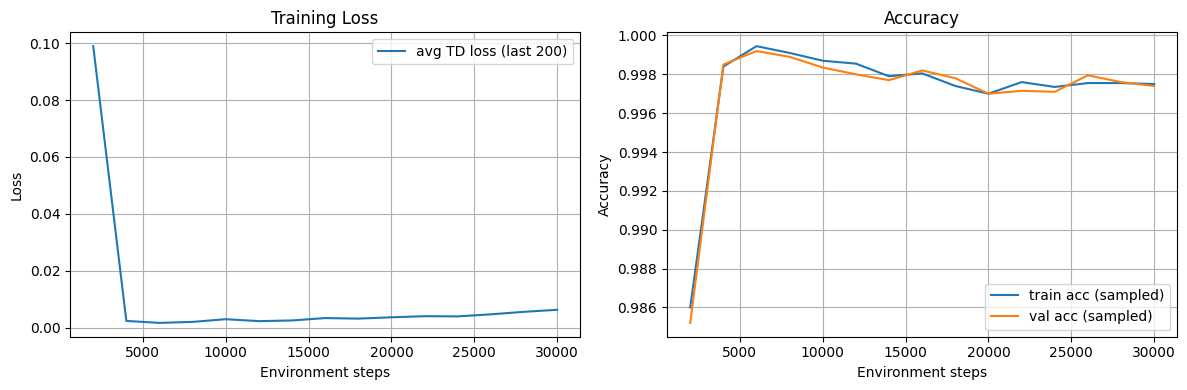

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(log_steps, avg_loss_hist, label="avg TD loss (last 200)")
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Environment steps")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(log_steps, train_acc_hist, label="train acc (sampled)")
axes[1].plot(log_steps, val_acc_hist, label="val acc (sampled)")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Environment steps")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

=== Validation (threshold=0, same as argmax) ===
Confusion matrix [[TN FP],[FN TP]]:
 [[22696    50]
 [   11    28]]
precision=0.3590 recall=0.7179 f1=0.4786

=== Validation (best F1 threshold on val) ===
best_th=0.668646  precision=0.7097 recall=0.5641 f1=0.6286
Confusion matrix [[TN FP],[FN TP]]:
 [[22737     9]
 [   17    22]]

PR-AUC(AP)=0.5741  ROC-AUC=0.8241


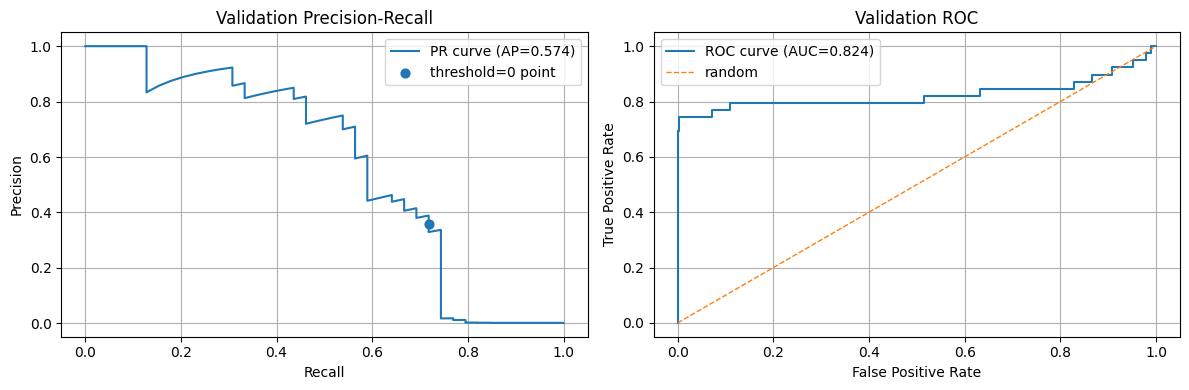

In [18]:
# One cell: meaningful validation graphs (PR curve + ROC curve) + best-threshold report
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_fscore_support,
)

policy_net.eval()

with torch.no_grad():
    Xv = torch.from_numpy(X_val).to(device)
    qv = policy_net(Xv).cpu().numpy()

# "fraud-likeness" score (higher => more fraud-like)
score_v = (qv[:, 1] - qv[:, 0]).astype(np.float32)

# Argmax / threshold=0 predictions
yhat0 = (score_v >= 0.0).astype(np.int64)
cm0 = confusion_matrix(y_val, yhat0, labels=[0, 1])
prec0, rec0, f10, _ = precision_recall_fscore_support(y_val, yhat0, average="binary", zero_division=0)

# Sweep thresholds to find best F1 on validation (simple + fast)
prec_curve, rec_curve, ths = precision_recall_curve(y_val, score_v)  # ths has len = len(prec)-1
f1_curve = (2 * prec_curve * rec_curve) / (prec_curve + rec_curve + 1e-12)
best_i = int(np.nanargmax(f1_curve))
best_f1 = float(f1_curve[best_i])
best_prec = float(prec_curve[best_i])
best_rec = float(rec_curve[best_i])

# Convert PR index to a usable threshold (handle edge indices)
if best_i == len(ths):  # last PR point corresponds to threshold below min(score)
    best_th = float(ths[-1]) - 1e-6
else:
    best_th = float(ths[max(0, best_i)])

yhat_best = (score_v >= best_th).astype(np.int64)
cm_best = confusion_matrix(y_val, yhat_best, labels=[0, 1])

ap = float(average_precision_score(y_val, score_v))
roc = float(roc_auc_score(y_val, score_v))

print("=== Validation (threshold=0, same as argmax) ===")
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm0)
print(f"precision={prec0:.4f} recall={rec0:.4f} f1={f10:.4f}")
print("\n=== Validation (best F1 threshold on val) ===")
print(f"best_th={best_th:.6f}  precision={best_prec:.4f} recall={best_rec:.4f} f1={best_f1:.4f}")
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm_best)
print(f"\nPR-AUC(AP)={ap:.4f}  ROC-AUC={roc:.4f}")

# Curves
fpr, tpr, _ = roc_curve(y_val, score_v)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(rec_curve, prec_curve, label=f"PR curve (AP={ap:.3f})")
axes[0].scatter([rec0], [prec0], s=40, label="threshold=0 point")
axes[0].set_title("Validation Precision-Recall")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(fpr, tpr, label=f"ROC curve (AUC={roc:.3f})")
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="random")
axes[1].set_title("Validation ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, average_precision_score

best_th = 0.668646  # from validation

policy_net.eval()
with torch.no_grad():
    q = policy_net(torch.from_numpy(X_test).to(device)).cpu().numpy()

score = (q[:,1] - q[:,0]).astype(np.float32)
y_hat = (score >= best_th).astype(np.int64)

cm = confusion_matrix(y_test, y_hat, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_hat, average="binary", zero_division=0)

print("=== TEST @ val-chosen threshold ===")
print("threshold:", best_th)
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
print(f"precision={prec:.4f} recall={rec:.4f} f1={f1:.4f}")
print(f"PR-AUC(AP)={average_precision_score(y_test, score):.4f}  ROC-AUC={roc_auc_score(y_test, score):.4f}")
print(f"predicted_fraud={(y_hat==1).sum()} / {len(y_hat)}")

=== TEST @ val-chosen threshold ===
threshold: 0.668646
Confusion matrix [[TN FP],[FN TP]]:
 [[56844    20]
 [   41    57]]
precision=0.7403 recall=0.5816 f1=0.6514
PR-AUC(AP)=0.6687  ROC-AUC=0.9205
predicted_fraud=77 / 56962
